# DDPG ball position controller
In this section, the ball controller will be created.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

## PID benchmark
In this section, a traditional PID controller will be designed as a benchmark.

### Target trajectory

In [3]:
def step(duration: float, amplitude: tuple)-> np.ndarray:
    iterations = int((duration // DT))
    ts = np.ones((2, iterations))
    ts[0, :] = amplitude[0] * ts[0, :]
    ts[1, :] = amplitude[1] * ts[1, :]
    return ts

In [4]:
def circle(duration: float, raduis: float)-> np.ndarray:
    pause = int(5. / DT)
    iterations = int(duration // DT)
    ts = np.zeros((2, iterations + pause))
    t = 2. * np.pi / duration * np.linspace(0., duration, num=iterations)
    ts[1, pause:] = raduis * np.cos(t)
    ts[0, pause:] = raduis * np.sin(t)
    ts[1, :pause] = raduis * np.ones(pause)
    return ts

In [5]:
trajectory = np.zeros((2, 100))

for _ in range(2):
    pos = 2. * np.random.rand(2) - 1.
    trajectory = np.hstack((trajectory, step(10., ((0.8 * MAX_X) * pos[0], (0.8 * MAX_Y) * pos[1]))))

for _ in range(1):
    t = 40. * (0.5 + (np.random.rand() / 2.))
    r = (np.random.rand() - 0.5) * (1.6 * MAX_Y)
    trajectory = np.hstack((trajectory, circle(t, r)))

<IPython.core.display.Javascript object>


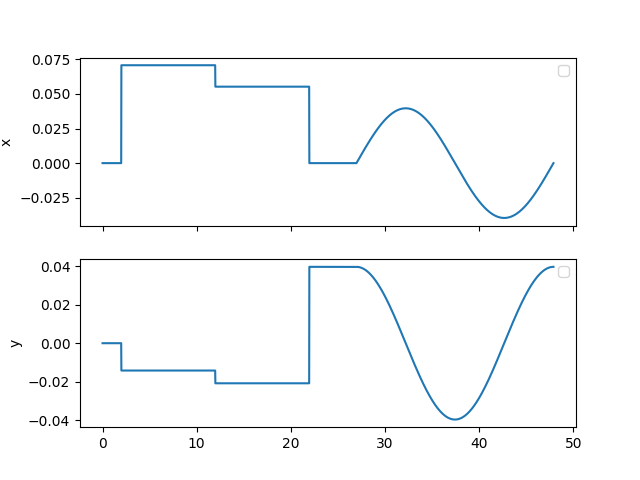

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [6]:
t = np.arange(0., trajectory.shape[1] * DT, DT)

fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(t, trajectory[0, :])
axs[0].set_ylabel('x')
axs[0].legend()

axs[1].plot(t, trajectory[1, :])
axs[1].set_ylabel('y')
axs[1].legend()

plt.show()

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.005814008976401043, -0.001408097781089559, -0.0016082474418295553, -0.0001702183355398653], [0.002803128310088574, 0.004822095077365393, -9.717955355255901e-05, -0.0011515859971490835]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05724771,  0.04024017], dtype=float32), array([-0.01183409, -0.01580459], dtype=float32), array([0.01120952, 0.00272726], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Generation = 1
Fitness    = -0.0013303767051389835
Generation = 2
Fitness    = -0.000495866586335197
Generation = 3
Fitness    = -0.0002965212849798296
Generation = 4
Fitness    = -0.00021476214785234006
Generation = 5
Fitness    = -0.00019233945303248173
Generation = 6
Fitness    = -0.0001762627959464988
Generation = 7
Fitness    = -0.00019992114208114962
Generation = 8
Fitness    = -0.00018994444833604081
Generation = 9
Fitness    = -0.00019284463533172805
Generation = 10
Fitness    = -0.00020142375479237552
Generation = 11
Fitness    = -0.00020213108050416893
Generation = 12
Fitness    = -0.0001978059878018609
Generation = 13
Fitness    = -0.0001842526935018934
Generation = 14
Fitness    = -0.00017903916481963266
Generation = 15
Fitness    = -0.00017914273270472515


<IPython.core.display.Javascript object>


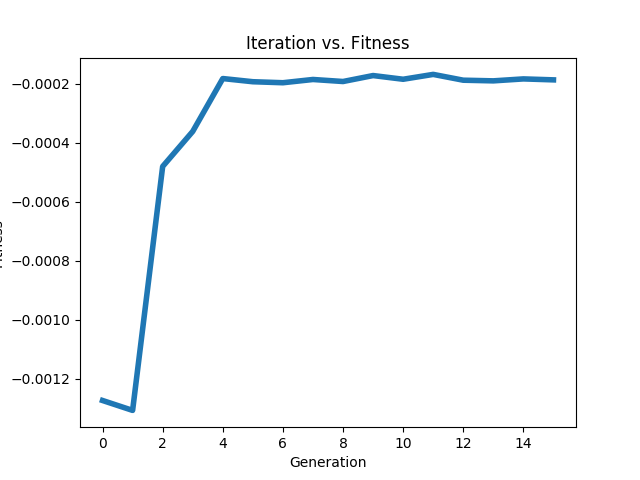

Fitness value of the best solution = -0.00019279736812492416


In [7]:
pid_controller = train_ball_controller(trajectory, 15, 20)

In [8]:
evaluator: BenchmarkEvaluator = BenchmarkEvaluator(trajectory)
    
history_pid, error_pid, u_pid, angle_pid, loss_pid = evaluator.simulate(pid_controller)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.005814008976401043, -0.001408097781089559, -0.0016082474418295553, -0.0001702183355398653], [0.002803128310088574, 0.004822095077365393, -9.717955355255901e-05, -0.0011515859971490835]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.061554  ,  0.01668577], dtype=float32), array([0.02989893, 0.06462097], dtype=float32), array([-0.01062774,  0.00573316], dtype=float32))


In [10]:
w = pid_controller.predict.weight[0].detach().numpy().tolist()
print(w)

ball_pid = {
    'weights': [w[0] * BALL_ERROR_SCALING, w[1] * BALL_D_ERROR_SCALING, w[2] * BALL_INTEGRAL_ERROR_SCALING],
}

with open('src/data/ball_pid.json', 'w') as json_file:
    json.dump(ball_pid, json_file)

[1.858559012413025, 1.0482550859451294, 0.011416701599955559]


## DDPG

In this section two DDPG agents will be trained :

- black box controller
- dynamic pid controller

In [11]:
spinup.ddpg_pytorch(BBEnv,
                    ac_kwargs = dict(hidden_sizes=[100, 50], activation=torch.nn.ReLU), 
                    seed = 0, 
                    steps_per_epoch = 2000, 
                    epochs = 100, 
                    replay_size = 800000, 
                    gamma = 0.99, 
                    polyak = 0.995, 
                    pi_lr = 0.001,
                    q_lr = 0.001,
                    batch_size = 2500, 
                    start_steps = 15000,
                    act_noise = 0.1,
                    max_ep_len = 300,
                    update_every=50,
                    num_test_episodes=20,
                    logger_kwargs = dict(output_dir='src/data/ddpg_model_penality', exp_name='test'),
                    )

Logging data to src/data/ddpg_model_penality/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100,
            50
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	2500,
    "env_fn":	"BBEnv",
    "epochs":	100,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7fcce09400b8>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/ddpg_model_penality",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/ddpg_model_penality/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"test",
        "output_dir":	"src/data/ddpg_model_penality

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |            -128 |
|          StdEpRet |            82.1 |
|          MaxEpRet |           -16.1 |
|          MinEpRet |            -267 |
|  AverageTestEpRet |            -129 |
|      StdTestEpRet |            47.4 |
|      MaxTestEpRet |             -46 |
|      MinTestEpRet |            -225 |
|             EpLen |             232 |
|         TestEpLen |             139 |
| TotalEnvInteracts |         1.4e+04 |
|      AverageQVals |           -10.5 |
|          StdQVals |            19.4 |
|          MaxQVals |            84.2 |
|          MinQVals |           -83.8 |
|            LossPi |            10.2 |
|             LossQ |             2.4 |
|              Time |             227 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            -128 |
|          StdEpRet |            43.9 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |            10.3 |
|          StdEpRet |            19.2 |
|          MaxEpRet |            40.4 |
|          MinEpRet |           -5.54 |
|  AverageTestEpRet |            37.5 |
|      StdTestEpRet |              30 |
|      MaxTestEpRet |            94.6 |
|      MinTestEpRet |           -19.7 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |         3.4e+04 |
|      AverageQVals |            11.8 |
|          StdQVals |            38.1 |
|          MaxQVals |             147 |
|          MinQVals |            -164 |
|            LossPi |           -12.5 |
|             LossQ |            3.27 |
|              Time |             861 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |            47.7 |
|          StdEpRet |            48.7 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |            62.8 |
|          StdEpRet |            27.7 |
|          MaxEpRet |             101 |
|          MinEpRet |            28.6 |
|  AverageTestEpRet |            50.6 |
|      StdTestEpRet |            27.2 |
|      MaxTestEpRet |             105 |
|      MinTestEpRet |            4.03 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |         5.4e+04 |
|      AverageQVals |              36 |
|          StdQVals |            38.5 |
|          MaxQVals |             219 |
|          MinQVals |            -151 |
|            LossPi |           -36.7 |
|             LossQ |             2.9 |
|              Time |        1.29e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |            72.3 |
|          StdEpRet |            32.3 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |            41.8 |
|          StdEpRet |            17.7 |
|          MaxEpRet |            68.8 |
|          MinEpRet |            12.1 |
|  AverageTestEpRet |            66.1 |
|      StdTestEpRet |            36.4 |
|      MaxTestEpRet |             133 |
|      MinTestEpRet |            3.51 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |         7.4e+04 |
|      AverageQVals |            45.5 |
|          StdQVals |            34.1 |
|          MaxQVals |             163 |
|          MinQVals |            -185 |
|            LossPi |           -46.1 |
|             LossQ |             2.5 |
|              Time |        1.72e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |            85.9 |
|          StdEpRet |            32.6 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |            58.6 |
|          StdEpRet |            36.6 |
|          MaxEpRet |             100 |
|          MinEpRet |            11.5 |
|  AverageTestEpRet |            58.9 |
|      StdTestEpRet |            30.1 |
|      MaxTestEpRet |             125 |
|      MinTestEpRet |           -0.19 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |         9.4e+04 |
|      AverageQVals |            45.6 |
|          StdQVals |            29.8 |
|          MaxQVals |             158 |
|          MinQVals |            -171 |
|            LossPi |           -46.1 |
|             LossQ |            2.08 |
|              Time |        2.18e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |              82 |
|          StdEpRet |            48.9 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |            67.4 |
|          StdEpRet |            39.6 |
|          MaxEpRet |             147 |
|          MinEpRet |            19.5 |
|  AverageTestEpRet |            64.1 |
|      StdTestEpRet |              36 |
|      MaxTestEpRet |             155 |
|      MinTestEpRet |            17.1 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |        1.14e+05 |
|      AverageQVals |            41.3 |
|          StdQVals |            27.2 |
|          MaxQVals |             156 |
|          MinQVals |            -171 |
|            LossPi |           -41.7 |
|             LossQ |            1.74 |
|              Time |        2.63e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |            67.8 |
|          StdEpRet |            13.2 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |            51.7 |
|          StdEpRet |            29.6 |
|          MaxEpRet |            97.3 |
|          MinEpRet |            13.2 |
|  AverageTestEpRet |            66.5 |
|      StdTestEpRet |            35.4 |
|      MaxTestEpRet |             143 |
|      MinTestEpRet |            19.3 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |        1.34e+05 |
|      AverageQVals |            37.5 |
|          StdQVals |            26.2 |
|          MaxQVals |             151 |
|          MinQVals |            -165 |
|            LossPi |           -37.9 |
|             LossQ |             1.5 |
|              Time |        3.07e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |            54.6 |
|          StdEpRet |              28 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |            81.8 |
|          StdEpRet |              44 |
|          MaxEpRet |             140 |
|          MinEpRet |            9.89 |
|  AverageTestEpRet |            56.8 |
|      StdTestEpRet |            44.5 |
|      MaxTestEpRet |             139 |
|      MinTestEpRet |             -47 |
|             EpLen |             300 |
|         TestEpLen |             295 |
| TotalEnvInteracts |        1.54e+05 |
|      AverageQVals |            35.9 |
|          StdQVals |            24.3 |
|          MaxQVals |             193 |
|          MinQVals |            -158 |
|            LossPi |           -36.2 |
|             LossQ |             1.2 |
|              Time |        3.47e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |            23.9 |
|          StdEpRet |            42.2 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |            65.6 |
|          StdEpRet |            28.4 |
|          MaxEpRet |             100 |
|          MinEpRet |            22.5 |
|  AverageTestEpRet |            65.9 |
|      StdTestEpRet |            32.9 |
|      MaxTestEpRet |             127 |
|      MinTestEpRet |            12.5 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            33.4 |
|          StdQVals |            23.7 |
|          MaxQVals |             155 |
|          MinQVals |            -157 |
|            LossPi |           -33.7 |
|             LossQ |           0.987 |
|              Time |        3.89e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |            85.2 |
|          StdEpRet |              43 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |            65.8 |
|          StdEpRet |            24.6 |
|          MaxEpRet |             108 |
|          MinEpRet |            30.6 |
|  AverageTestEpRet |            72.8 |
|      StdTestEpRet |            33.5 |
|      MaxTestEpRet |             137 |
|      MinTestEpRet |            10.2 |
|             EpLen |             300 |
|         TestEpLen |             300 |
| TotalEnvInteracts |        1.94e+05 |
|      AverageQVals |            31.1 |
|          StdQVals |            23.6 |
|          MaxQVals |             141 |
|          MinQVals |            -149 |
|            LossPi |           -31.3 |
|             LossQ |           0.998 |
|              Time |        4.23e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |            61.3 |
|          StdEpRet |            36.9 |


In [12]:
ac = torch.load('src/data/ddpg_model_penality/pyt_save/model.pt')

In [13]:
evaluator_ddpg = BBEnv()

history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(ac, trajectory)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.005814008976401043, -0.001408097781089559, -0.0016082474418295553, -0.0001702183355398653], [0.002803128310088574, 0.004822095077365393, -9.717955355255901e-05, -0.0011515859971490835]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00863925,  0.05815173], dtype=float32), array([-0.03768296, -0.01333543], dtype=float32), array([-0.00063204,  0.0090239 ], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [14]:
spinup.ddpg_pytorch(BBEnvPid,
                    actor_critic = PidActorCritic,
                    ac_kwargs = dict(hidden_sizes=[20, 10], activation=torch.nn.Sigmoid), 
                    seed = 0, 
                    steps_per_epoch = 2000, 
                    epochs = 100, 
                    replay_size = 800000, 
                    gamma = 0.99, 
                    polyak = 0.995, 
                    pi_lr = 0.001,
                    q_lr = 0.001,
                    batch_size = 2500, 
                    start_steps = 15000,
                    act_noise = 0.1,
                    max_ep_len = 300,
                    update_every=50,
                    num_test_episodes=20,
                    logger_kwargs = dict(output_dir='src/data/ddpg_model_pid_penality', exp_name='test'),
                    )

Logging data to src/data/ddpg_model_pid_penality/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            20,
            10
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	2500,
    "env_fn":	"BBEnvPid",
    "epochs":	100,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7fcce09402b0>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/ddpg_model_pid_penality",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/ddpg_model_pid_penality/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"test",
        "output_dir":	"src/data/dd

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            -255 |
|          StdEpRet |            68.3 |
|          MaxEpRet |            -159 |
|          MinEpRet |            -372 |
|  AverageTestEpRet |            -296 |
|      StdTestEpRet |              87 |
|      MaxTestEpRet |            -133 |
|      MinTestEpRet |            -449 |
|             EpLen |             137 |
|         TestEpLen |             138 |
| TotalEnvInteracts |         1.6e+04 |
|      AverageQVals |           -77.6 |
|          StdQVals |              14 |
|          MaxQVals |           -31.7 |
|          MinQVals |           -99.5 |
|            LossPi |            76.5 |
|             LossQ |            43.7 |
|              Time |             166 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            -305 |
|          StdEpRet |            70.2 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |            -216 |
|          StdEpRet |            74.4 |
|          MaxEpRet |            -130 |
|          MinEpRet |            -361 |
|  AverageTestEpRet |            -130 |
|      StdTestEpRet |            99.9 |
|      MaxTestEpRet |            44.6 |
|      MinTestEpRet |            -287 |
|             EpLen |             227 |
|         TestEpLen |             252 |
| TotalEnvInteracts |         3.6e+04 |
|      AverageQVals |           -83.7 |
|          StdQVals |            24.6 |
|          MaxQVals |           -17.2 |
|          MinQVals |            -145 |
|            LossPi |            83.1 |
|             LossQ |            22.3 |
|              Time |             401 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |            -192 |
|          StdEpRet |            35.6 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |            -203 |
|          StdEpRet |            56.2 |
|          MaxEpRet |            -106 |
|          MinEpRet |            -298 |
|  AverageTestEpRet |            -143 |
|      StdTestEpRet |            98.2 |
|      MaxTestEpRet |            6.01 |
|      MinTestEpRet |            -393 |
|             EpLen |             283 |
|         TestEpLen |             263 |
| TotalEnvInteracts |         5.6e+04 |
|      AverageQVals |           -80.3 |
|          StdQVals |            29.8 |
|          MaxQVals |           -12.6 |
|          MinQVals |            -166 |
|            LossPi |            79.9 |
|             LossQ |            17.2 |
|              Time |             601 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |            -215 |
|          StdEpRet |            73.1 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |            -221 |
|          StdEpRet |            57.6 |
|          MaxEpRet |            -143 |
|          MinEpRet |            -322 |
|  AverageTestEpRet |            -137 |
|      StdTestEpRet |              66 |
|      MaxTestEpRet |           -43.3 |
|      MinTestEpRet |            -275 |
|             EpLen |             245 |
|         TestEpLen |             270 |
| TotalEnvInteracts |         7.6e+04 |
|      AverageQVals |           -78.2 |
|          StdQVals |            28.6 |
|          MaxQVals |           -7.65 |
|          MinQVals |            -157 |
|            LossPi |              78 |
|             LossQ |            16.4 |
|              Time |             790 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |            -236 |
|          StdEpRet |            52.5 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |            -178 |
|          StdEpRet |            61.5 |
|          MaxEpRet |           -64.2 |
|          MinEpRet |            -238 |
|  AverageTestEpRet |            -107 |
|      StdTestEpRet |            90.1 |
|      MaxTestEpRet |            26.5 |
|      MinTestEpRet |            -331 |
|             EpLen |             286 |
|         TestEpLen |             283 |
| TotalEnvInteracts |         9.6e+04 |
|      AverageQVals |           -76.8 |
|          StdQVals |            28.3 |
|          MaxQVals |           -6.25 |
|          MinQVals |            -158 |
|            LossPi |            76.6 |
|             LossQ |            15.3 |
|              Time |             992 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |            -150 |
|          StdEpRet |            65.2 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |            -237 |
|          StdEpRet |            82.2 |
|          MaxEpRet |           -94.2 |
|          MinEpRet |            -344 |
|  AverageTestEpRet |            -137 |
|      StdTestEpRet |            56.1 |
|      MaxTestEpRet |            3.31 |
|      MinTestEpRet |            -213 |
|             EpLen |             251 |
|         TestEpLen |             256 |
| TotalEnvInteracts |        1.16e+05 |
|      AverageQVals |           -75.7 |
|          StdQVals |              28 |
|          MaxQVals |           -4.28 |
|          MinQVals |            -170 |
|            LossPi |            75.6 |
|             LossQ |            13.5 |
|              Time |        1.19e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |            -208 |
|          StdEpRet |            83.4 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |            -232 |
|          StdEpRet |            74.6 |
|          MaxEpRet |            -167 |
|          MinEpRet |            -393 |
|  AverageTestEpRet |            -121 |
|      StdTestEpRet |            89.9 |
|      MaxTestEpRet |            81.9 |
|      MinTestEpRet |            -330 |
|             EpLen |             259 |
|         TestEpLen |             254 |
| TotalEnvInteracts |        1.36e+05 |
|      AverageQVals |           -75.5 |
|          StdQVals |            27.2 |
|          MaxQVals |           -3.61 |
|          MinQVals |            -168 |
|            LossPi |            75.4 |
|             LossQ |            13.3 |
|              Time |        1.38e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |            -187 |
|          StdEpRet |            81.3 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |            -185 |
|          StdEpRet |              76 |
|          MaxEpRet |           -43.6 |
|          MinEpRet |            -311 |
|  AverageTestEpRet |           -87.9 |
|      StdTestEpRet |            63.4 |
|      MaxTestEpRet |            60.1 |
|      MinTestEpRet |            -256 |
|             EpLen |             276 |
|         TestEpLen |             273 |
| TotalEnvInteracts |        1.56e+05 |
|      AverageQVals |           -75.2 |
|          StdQVals |            26.3 |
|          MaxQVals |           -5.05 |
|          MinQVals |            -172 |
|            LossPi |            75.1 |
|             LossQ |            13.4 |
|              Time |        1.58e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |            -238 |
|          StdEpRet |            60.2 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |            -222 |
|          StdEpRet |            71.3 |
|          MaxEpRet |             -83 |
|          MinEpRet |            -294 |
|  AverageTestEpRet |            -134 |
|      StdTestEpRet |            59.5 |
|      MaxTestEpRet |          -0.365 |
|      MinTestEpRet |            -211 |
|             EpLen |             249 |
|         TestEpLen |             255 |
| TotalEnvInteracts |        1.76e+05 |
|      AverageQVals |           -74.9 |
|          StdQVals |            26.9 |
|          MaxQVals |           -4.19 |
|          MinQVals |            -173 |
|            LossPi |            74.8 |
|             LossQ |            13.4 |
|              Time |        1.79e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |            -207 |
|          StdEpRet |             104 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |            -230 |
|          StdEpRet |            53.3 |
|          MaxEpRet |            -176 |
|          MinEpRet |            -342 |
|  AverageTestEpRet |            -163 |
|      StdTestEpRet |            82.8 |
|      MaxTestEpRet |              17 |
|      MinTestEpRet |            -335 |
|             EpLen |             266 |
|         TestEpLen |             245 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |           -74.6 |
|          StdQVals |            27.2 |
|          MaxQVals |           -3.83 |
|          MinQVals |            -172 |
|            LossPi |            74.5 |
|             LossQ |            13.4 |
|              Time |        1.98e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |            -185 |
|          StdEpRet |            79.2 |


In [15]:
env_pid = BBEnvPid()

ac_pid = torch.load('src/data/ddpg_model_pid_penality/pyt_save/model.pt')

history_ddpg_pid, error_ddpg_pid, u_ddpg_pid, angle_ddpg_pid, loss_ddpg_pid, kp, kd, ki = env_pid.simulate(ac_pid, trajectory)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.005814008976401043, -0.001408097781089559, -0.0016082474418295553, -0.0001702183355398653], [0.002803128310088574, 0.004822095077365393, -9.717955355255901e-05, -0.0011515859971490835]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.05891176, 0.00318226], dtype=float32), array([-0.0034521 , -0.01388267], dtype=float32), array([1.7138045e-02, 7.1296548e-05], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Test

In this section, all controllers will be compared.

<IPython.core.display.Javascript object>


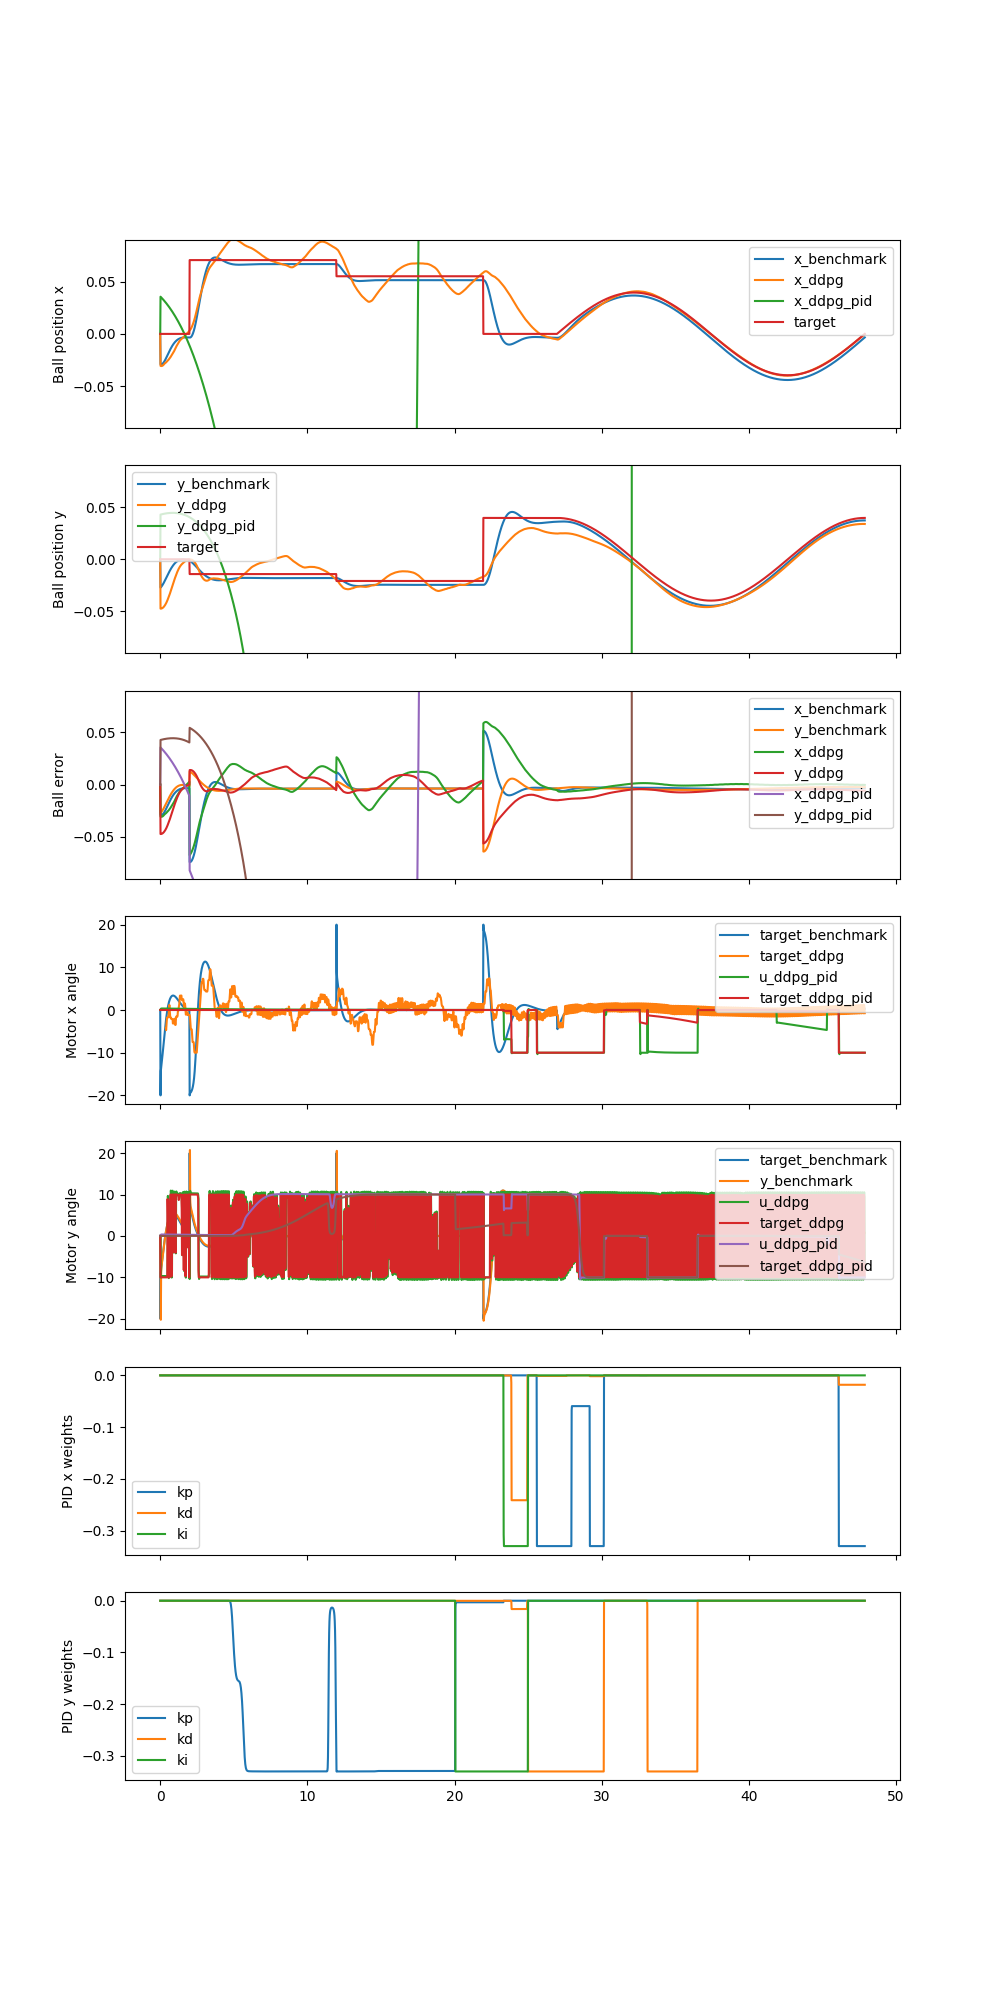

In [21]:
fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 20))

axs[0].plot(t, history_pid[0, :], label='x_benchmark')
axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, history_ddpg_pid[0, :], label='x_ddpg_pid')
axs[0].plot(t, trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_pid[1,:], label='y_benchmark')
axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, history_ddpg_pid[1,:], label='y_ddpg_pid')
axs[1].plot(t, trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_pid[0, :], label='x_benchmark')
axs[2].plot(t, error_pid[1, :], label='y_benchmark')
axs[2].plot(t, error_ddpg[0, :], label='x_ddpg')
axs[2].plot(t, error_ddpg[1, :], label='y_ddpg')
axs[2].plot(t, error_ddpg_pid[0, :], label='x_ddpg_pid')
axs[2].plot(t, error_ddpg_pid[1, :], label='y_ddpg_pid')
axs[2].set_ylabel('Ball error')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, u_pid[0, :], label='target_benchmark')
#axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t[19:], np.convolve(u_ddpg[0, :], np.ones(20), 'valid') / 20., label='target_ddpg')
axs[3].plot(t, angle_ddpg_pid[0, :], label='u_ddpg_pid')
axs[3].plot(t, u_ddpg_pid[0, :], label='target_ddpg_pid')
axs[3].set_ylabel('Motor x angle')
axs[3].legend()

axs[4].plot(t, u_pid[1, :], label='target_benchmark')
axs[4].plot(t, angle_pid[1, :], label='y_benchmark')
axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].plot(t, angle_ddpg_pid[1, :], label='u_ddpg_pid')
axs[4].plot(t, u_ddpg_pid[1, :], label='target_ddpg_pid')
axs[4].set_ylabel('Motor y angle')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()